In [13]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [14]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

In [25]:
sql = """
     select * from name_income
     where fips = '06'
     """

In [26]:
import pandas as pd

ca_df = pd.read_sql(sql, con=conn)
ca_df.head() #show the top 5 rows

/tmp/ipykernel_16910/3676184465.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ca_df = pd.read_sql(sql, con=conn)


,fips,name,income,year
0,06,California,53629,2005
1,06,California,56645,2006
2,06,California,59948,2007
3,06,California,61021,2008
4,06,California,58931,2009


<Axes: xlabel='year'>

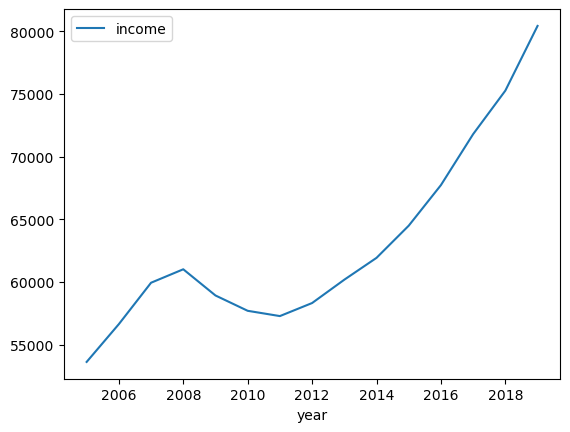

In [27]:
va_df.plot(x='year', y='income')

In [32]:
sql_yoy_ca = """
SELECT
    year,
    income,
    LAG(income) OVER (ORDER BY year) AS prev_income,
    ROUND((income - LAG(income) OVER (ORDER BY year))::numeric / LAG(income) OVER (ORDER BY year) * 100, 2) AS yoy_growth
FROM name_income
WHERE fips = '06'
ORDER BY year;
"""


/tmp/ipykernel_16910/4248620718.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ca_yoy_df = pd.read_sql(sql_yoy_ca, con=conn)


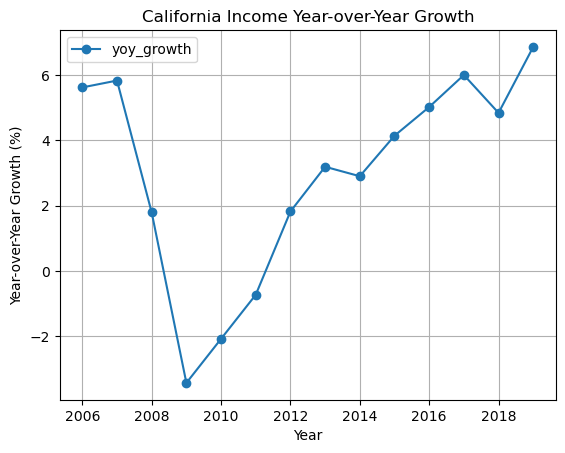

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# SQL query with YoY growth for California
sql_yoy_ca = """
SELECT
    year,
    income,
    LAG(income) OVER (ORDER BY year) AS prev_income,
    ROUND((income - LAG(income) OVER (ORDER BY year))::numeric / LAG(income) OVER (ORDER BY year) * 100, 2) AS yoy_growth
FROM name_income
WHERE fips = '06'
ORDER BY year;
"""

# Load the result into a DataFrame
ca_yoy_df = pd.read_sql(sql_yoy_ca, con=conn)

# Plot YoY growth rate
ax = ca_yoy_df.plot(x='year', y='yoy_growth', marker='o', linestyle='-')
ax.set_xlabel("Year")
ax.set_ylabel("Year-over-Year Growth (%)")
ax.set_title("California Income Year-over-Year Growth")
plt.grid(True)
plt.show()
